- Sara Arenas
- Cristhian Alejo
- Santiago Almeida

In [1]:
!pip install kneed
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 11.2 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.0-py2.py3-none-any.whl size=42487 sha256=77f65a699b8755361a2a7c18b29e09647a9a28eea96c1a2817a6e36abc7a95e6
  Stored in directory: /root/.cache/pip/wheels/74/a2/6c/26fb1addf1ce6c60a8cef8397f2999f0a1e6e2fcddc8abf33e
Successfully built factor_analyzer


In [2]:
# Librerias

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

#### Reduccion dimensiones

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from factor_analyzer import FactorAnalyzer

### Clustering
from sklearn import mixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#df = pd.read_csv('/content/drive/MyDrive/Analitica II/Aprendizaje no supervisado /Entregable 1/credit_card_clients.csv')
df= pd.read_csv('/content/drive/MyDrive/ANALITICA 2/Copia de credit_card_clients.csv')
df.dtypes
df.shape

(8950, 18)

In [5]:
# Analisis Exploratorio df
df2 = df.copy()
df2 = df2.drop('CUST_ID',axis = 1) # Eliminamos la columna CUST ID ya que es tipo objeto y vamos a trabajar solo con variables numericas
#Datos nulos

df2.isnull().sum() # identificamos nulos en la variable MINIMUM_PAYMENTS(313) y en CREDIT_LIMIT(1) con un total de 314 datos nulos
df2 = df2.dropna() # Elimina las filas que al menos tenga un nulo ya que consideramos que es un error de elaboracion de la base, ya que la variable payments no tiene nulos
#por lo cual lo mas coherente es que si exista un pago minimo

#Datos duplicados
df2[df2.duplicated()] # La base de datos no cuenta con datos duplicados

df2.dtypes
df2.shape

(8636, 17)

In [6]:
#Datos atipicos
def calcular_limites_outliers(data):
  """
  Calcula los límites de los datos atípicos para un conjunto de datos.

  Args:
    data: El conjunto de datos a analizar.

  Returns:
    Un tupla con el límite inferior y el límite superior de los datos atípicos.
  """

  # Calcula la media y la desviación estándar de los datos.
  media = data.mean()
  desviacion_estandar = data.std()

  # Calcula los límites de los datos atípicos.
  limite_inf = media - 3 * desviacion_estandar
  limite_sup = media + 3 * desviacion_estandar


  return limite_inf,limite_sup

def detectar_outliers(df):
  """
  Detecta los datos atípicos en un dataframe por cada una de sus columnas.

  Args:
    df: El dataframe a analizar.

  Returns:
    Un diccionario con el nombre de la variable y la cantidad de datos atípicos.
  """

  outliers = {}
  for col in df.columns:
    # Calcula los límites de los datos atípicos.
    limites = calcular_limites_outliers(df[col])

    # Identifica los datos atípicos.
    outliers[col] = df[col].loc[(df[col] < limites[0]) | (df[col] > limites[1])].shape[0]

    # filtrar valores no atípicos
    df5 = df[(df[col]> limites[0]) & (df[col]< limites[1] )]


  return df5




In [7]:
df3= detectar_outliers(df2) #Eliminamos los datos atipicos ya que PCA es muy sensible a estos datos

df3

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000,0,12,7500.0,622.066742,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8877,55.147722,0.875000,163.31,0.00,163.31,0.000000,0.875000,0.000000,0.750000,0.000,0,7,1000.0,62.619008,109.580539,0.000000,8
8878,869.328293,0.750000,0.00,0.00,0.00,1153.925205,0.000000,0.000000,0.000000,0.125,3,0,1200.0,150.755024,337.986933,0.000000,8
8879,137.744895,1.000000,441.00,0.00,441.00,0.000000,0.750000,0.000000,0.625000,0.000,0,6,1000.0,169.249683,124.639905,0.000000,8
8880,331.070135,0.750000,81.20,81.20,0.00,419.341394,0.125000,0.125000,0.000000,0.250,7,1,500.0,116.761487,205.065526,0.000000,8


In [8]:
df_escalada = StandardScaler().fit_transform(df3) # Escalamos todas las variables con el objetivo de tener un mejor rendimiento en el modelo

A continuacion vamos a aplicar PCA para reduccion de dimensiones, en este modelo elegimos inicialmente 17 componentes con el fin de abarcar todas las variables y ver su respectiva significancia,
con lo cual posteriormente vamos a utilizar la regla del codo y elegir mas componentes significativos

In [9]:
pca=PCA(n_components=17)

pca.fit(df_escalada)

PCA(n_components=17)

In [10]:
pca.components_ ## lambdas, vectores propios pesos de observadas sobre latentes

array([[ 8.70939076e-02,  1.06536658e-01,  4.11904316e-01,
         3.46536771e-01,  3.36618151e-01, -3.29748238e-02,
         3.27424131e-01,  2.96018624e-01,  2.79544170e-01,
        -9.89697391e-02, -5.94157074e-02,  3.90976922e-01,
         2.07235736e-01,  2.62422045e-01,  5.50854306e-02,
         1.35695628e-01,  6.69788499e-02],
       [ 4.05635551e-01,  1.30098945e-01,  5.20430517e-02,
         7.12480526e-02, -8.05762546e-03,  4.37210113e-01,
        -1.80435189e-01, -1.52884930e-02, -1.67084009e-01,
         4.33909931e-01,  4.17392143e-01, -8.53408066e-03,
         2.43008013e-01,  2.67426285e-01,  1.70401629e-01,
        -1.91079582e-01, -1.18041111e-02],
       [-1.76897403e-01, -4.61013605e-01,  2.41039611e-01,
         3.64866670e-01, -1.01091090e-01,  6.46862154e-03,
        -3.51697587e-01,  9.73788608e-02, -4.43524796e-01,
        -8.49785905e-02, -7.79256166e-02, -8.29145383e-02,
         9.49750996e-02,  2.92050233e-01, -2.50460624e-01,
         1.96074454e-01, -9.5

In [11]:
pca.explained_variance_ ## valores propios alpha, cuánta varianza es explicada
ve=pca.explained_variance_ratio_ ### procentaje de variable explicada por cada componente
ve

array([2.72364737e-01, 2.04228683e-01, 8.94790561e-02, 7.39295204e-02,
       6.25621465e-02, 5.77137005e-02, 4.98737946e-02, 4.24603162e-02,
       3.66498688e-02, 3.07939218e-02, 2.36808133e-02, 1.77860776e-02,
       1.43383308e-02, 1.15570469e-02, 9.84806103e-03, 2.73322977e-03,
       6.95181013e-07])

In [12]:
l = pca.transform(df3) ## variables latentes
l[0] ## variables latentes para primera fila

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


array([ 344.59998998,  341.43862832,  123.29982927,  150.3511475 ,
        237.4520287 , -254.04640278, -534.37793228, -291.36378172,
        121.33199463,  101.2360972 ,   83.55818671,  377.58143428,
       -363.28619489,   68.16370543,  -49.48625868,   20.13284714,
        -41.23349822])

*RESPUESTA PREGUNTA 1 : 1. Cuáles son las variables observadas más importantes en las dos variables latentes más importantes.*

- L1 --> Para la variable latente L1, PURCHASES,	ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,	CASH_ADVANCE_TRX, PURCHASES_FREQUENCY.
- L2 --> Para la variable latente L2, las variables observadas mas importantes son: cash_advance, cash_advance_frecuency, cash_advance_trx, balance y payments

<ipython-input-13-ec52bdf834a3>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=np.arange(1,18), y=np.cumsum(ve), palette="viridis")


7

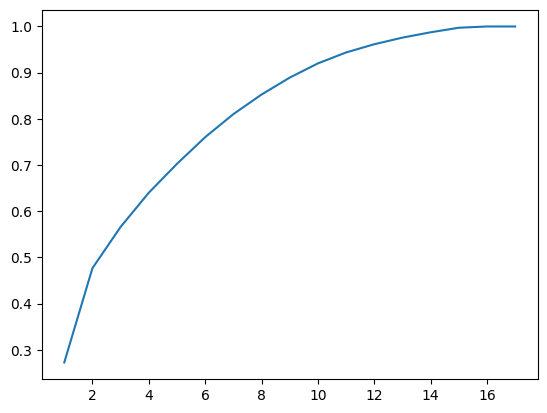

In [13]:
#Utilizamos la regra del codo para analizar los componentes optimos a utilizar
sns.lineplot(x=np.arange(1,18), y=np.cumsum(ve), palette="viridis")
kl = KneeLocator(x=np.arange(1,18),y=np.cumsum(ve),curve = 'concave',direction = 'increasing')
kl.elbow

#Segun lo observado podemos observar que la regla del codo nos recomienda utilizar 7 componentes
#para tener mayor representabilidad de las variables

*RESPUESTA PREGUNTA 2 : 2. Qué porcentaje de variación va a explicar y cuántas variables latentes va a utilizar para representar los datos.*
- Tras utilizar la regla del codo, decidimos utilizar 8 variables latentes las cuales tienen la capacidad de representar mas del 80% de la varianza de los datos

In [14]:
l_sel=l[:,0:8] # Seleccionamos los componenetes sugeridos por la regla del codo

In [15]:
l_sel

array([[  344.59998998,   341.43862832,   123.29982927, ...,
         -254.04640278,  -534.37793228,  -291.36378172],
       [ 2653.57543609,  7098.71113772,  1067.85148917, ...,
        -2809.11304572, -4703.59386461, -2277.26125892],
       [ 2562.00790667,  3202.94383069,   761.10358211, ...,
        -1752.74453133, -4757.31400524, -2622.27054171],
       ...,
       [  604.02008782,   384.52517714,   148.27345254, ...,
         -163.20032748,  -397.26730618,  -408.64246537],
       [  222.79066661,   518.31831366,    21.7816706 , ...,
         -130.61079219,  -374.67688847,   -92.98479843],
       [  230.17348708,   695.61226604,   215.26475864, ...,
         -304.27021396,  -242.38510421,  -153.28090511]])

<Axes: >

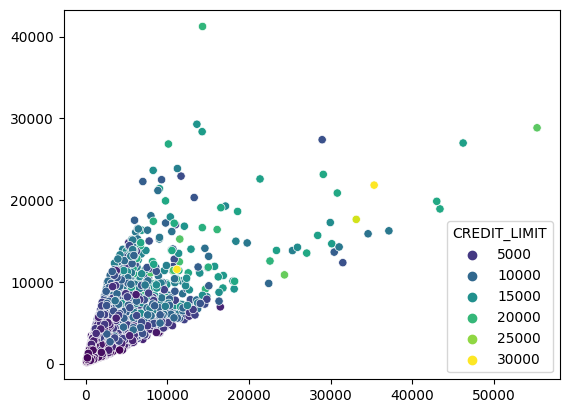

In [16]:
####3 para graficar los datos originales de iris con la transformación

sns.scatterplot(x=l_sel[:,0], y=l_sel[:,1], hue=df3['CREDIT_LIMIT'],palette = 'viridis')

# Cluster

array([9.95786716e-01, 0.00000000e+00, 1.08955389e-05, 1.89131253e-07,
       2.79941298e-15, 4.20216329e-03, 2.98259165e-10, 3.60719593e-08])

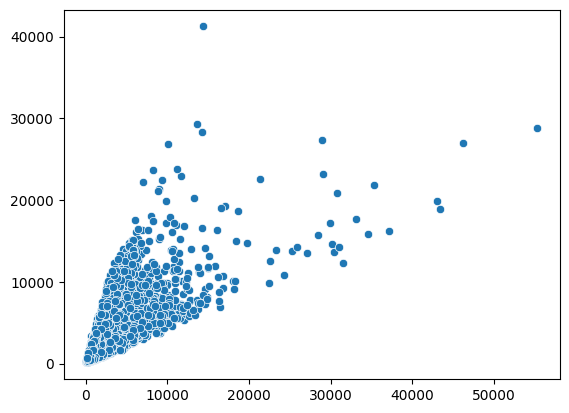

In [17]:

sns.scatterplot(x=l_sel[:,0], y=l_sel[:,1])
#n_components: los cluster
#covariance: matriz de covarianza
#n_init
gmm=mixture.GaussianMixture(n_components=8, covariance_type='full', n_init=5)

mixture.GaussianMixture()
gmm.fit(l_sel)
#gmm.aic(l_sel) ## indicador para comparar con otro modelo por si solo no se interpreta
gmm.bic(l_sel)
gmm.score(l_sel)#verosimilitud
gmm.predict_proba(l_sel)[0]

In [18]:
paramg = {
    'n_components': [1,2,3,4,5,6,7,8,9],# numero de cluster
    'covariance_type': ['full','tide','spherical','diag'],
    'n_init':[4,5,6]
}

In [19]:
# Modelo optimizacion hiperparametros
r2 = RandomizedSearchCV(gmm, paramg, cv=5, n_iter=100, random_state=42, n_jobs=-1)
r2.fit(l_sel)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
130 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 684, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py", line 186, in fit
    self.fit_predict(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py", line 216, in fit_predict
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, 

RandomizedSearchCV(cv=5, estimator=GaussianMixture(n_components=8, n_init=5),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'covariance_type': ['full', 'tide',
                                                            'spherical',
                                                            'diag'],
                                        'n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9],
                                        'n_init': [4, 5, 6]},
                   random_state=42)

In [20]:
df_resultados = pd.DataFrame(r2.cv_results_)
df_resultados[['params','mean_test_score']].sort_values(by = 'mean_test_score', ascending = False).head(1)# Tras optimizar los hiperparametros, utilizaremos 9 clusters y una matriz de covarianza 'full'

,params,mean_test_score
23,"{'n_init': 6, 'n_components': 9, 'covariance_t...",-48.484507


array([9.99807709e-01, 0.00000000e+00, 2.34773443e-15, 4.29398155e-11,
       2.50756781e-13, 1.89422232e-04, 2.86618278e-06, 3.02807814e-09,
       0.00000000e+00])

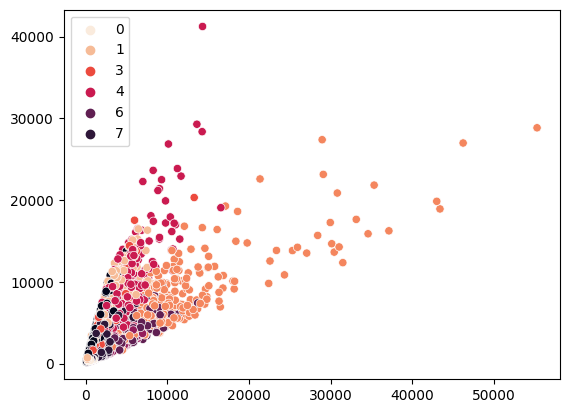

In [21]:
gmm_gan=r2.best_estimator_
cluster=gmm_gan.fit_predict(l_sel)
sns.scatterplot(x=l_sel[:,0], y=l_sel[:,1], hue=cluster,palette='rocket_r')
gmm_gan.predict_proba(l_sel)[0]

Debido a que tenemos muchos clusters y en el campo de estudio de segmentacion de clientes no nos conviene trabajar con esta cantidad, a continuacion procederemos a ajustar un modelo con 3 clusters

array([9.99034757e-01, 1.21820231e-09, 9.65242042e-04])

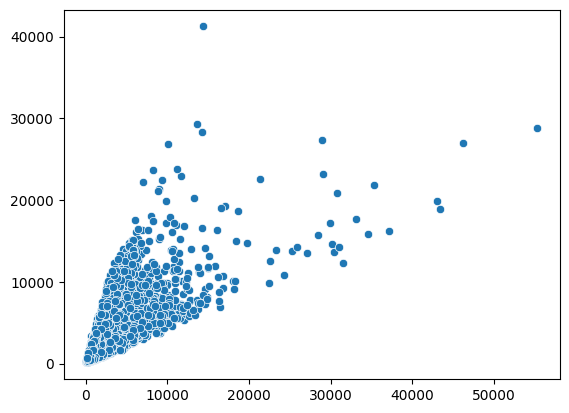

In [22]:
sns.scatterplot(x=l_sel[:,0], y=l_sel[:,1])
#n_components: los cluster
#covariance: matriz de covarianza
#n_init
gmm=mixture.GaussianMixture(n_components=3, covariance_type='full', n_init=2)

mixture.GaussianMixture()
gmm.fit(l_sel)

gmm.score(l_sel)#verosimilitud
gmm.predict_proba(l_sel)[0]

In [37]:
cluster=gmm.fit_predict(l_sel)

<Axes: >

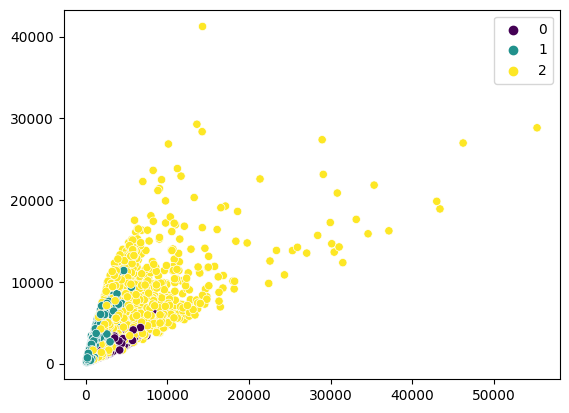

In [38]:
sns.scatterplot(x=l_sel[:,0], y=l_sel[:,1], hue=cluster,palette='viridis')

al realizar el modelo con 3 cluster permite observar una mejor segmentacion de los clientes

<Axes: ylabel='PURCHASES'>

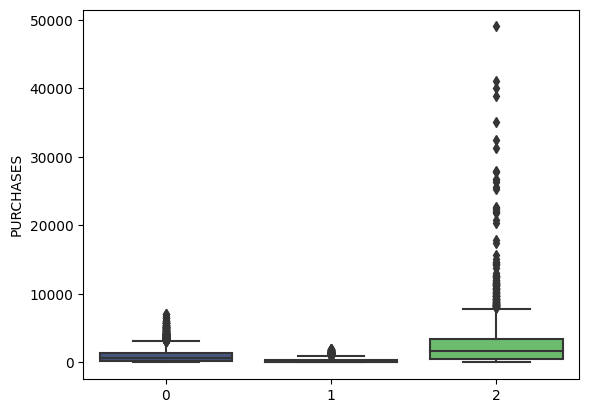

In [36]:
# Clusters Vs Variables
sns.boxplot(x=cluster, y= df3['PURCHASES'],palette = 'viridis') # Analizamos el valor promedio de los productos que nuestros usuarios han adquiridos durante los ultimos 6 meses

Segun lo observado en la grafica Boxplot se puede observar que los clientes segmentados en el cluster 1 puede que compren productos economicos, por lo cual tienen menor saldo disponible a comparacion de los demas clientes

<Axes: ylabel='ONEOFF_PURCHASES'>

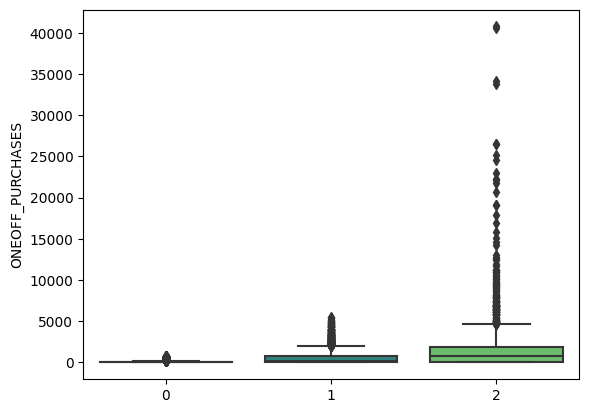

In [32]:
sns.boxplot(x=cluster, y= df3['ONEOFF_PURCHASES'],palette = 'viridis') # Valor del producto adquirido a una sola cuota

Analizando los productos que nuestros clientes compran a una cuota podemos observar que a pesar de tener una media de pago a una cuota en todos los clusters muy cercana, los clientes del segmento 2 cuenta con pagos a una cuota con valores muchos mas elevados, lo que indicaria que estos clientes manejan grandes cantidades de dinero

In [39]:
base = df3.groupby(cluster)[['PURCHASES_FREQUENCY']].mean().reset_index().rename(columns = {'index':'cluster'})
px.bar(base,x = 'cluster' ,y= 'PURCHASES_FREQUENCY',title = 'Frecuencia de uso de tarjetas de credito segun cada tipo de cliente')

RESPUESTA 3 : 3. *Diga cuáles son las principales diferencias entre los segmentos encontrados.*

- Segun lo observado en la grafica podemos inferir lo siguiente:
   - **segmento 0 :** representa parte de la minoria de los clientes, sin embargo usan la tarjeta de credito con casi la misma frecuencia que los clientes del segmento 2
   - **segmento 1 :**representa un porcentaje mayor de la minoria, estos clientes   se caracterizan por tener un bajo uso de la tarjeta de credito adquiriendo productos durante los 6 meses que no superan los $10.000
   - **segmento 2 :** podemos inferir que este segmento  representa a la mayoria de nuestros clientes los cuales han realizado compras por encima de la media de los segmentos 0 y 1, adicionalmente son los que mas uso le dan a la tarjeta de credito.

RESPUESTA 4: 4. Con base en las características identificadas en los segmentos proponga alguna estrategia que se pueda implementar en cada uno.                                                                                                                                                                  


> **ESTRATEGIAS**




- Segmento 0 : aplicaremos estategias de *cashback* ya que estos clientes usan mucho la tarjeta, por lo cual nos interesa matenerlos
- Segmento 1 :  al ser un cliente que compra en baja cantidad y ademas usa la tarjeta con poca frecuencia podemos aplicar una estrategia de descuentos al pagar con tarjeta de credito en productos especifios que sean de interes de estos clientes; con el objetivo de incentivar el uso de la tarjeta.
- Segmento 2 : recurriremos a una estrategia disminución de intereses sobre las cuotas de credito, ya que este cliente maneja valores altos de compra por lo cual, este tipo de estrategia le resulta mas atractiva.